## Imports

In [ ]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass
# Torch
import torch
from torch.utils.data import DataLoader
# VAE
from models import VAE
from train import train_vae
from utils import generate_vae, project_samples
# GAN
from models import Autoencoder, GAN
from train import train_autoencoder, train_gan
from utils import generate_samples
# BN
from pomegranate import *
# Copula
from utils import Copula_scaler, pseudo_inverse
# Utils
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Evaluation
from utils import srmse
from sdmetrics import single_column
from sdv.metrics.tabular import CSTest, SVCDetection

# Traditional population synthesis

Generation of whole maryland

## Data

In [2]:
df = pd.read_csv("data/maryland.csv").drop(["PUMA"], axis=1).sample(frac=1)
train, test = train_test_split(df, test_size=0.15)
train.to_csv("data/trainTest/train.csv", index=False)
test.to_csv("data/trainTest/test.csv", index=False)

train = pd.read_csv("data/trainTest/train.csv")
test = pd.read_csv("data/trainTest/test.csv")

columns = train.columns
metadata = {"fields":{}}
for col in columns:
    metadata["fields"][col] = {"type": "categorical"}

In [3]:
models = ["BN", "BNcopula", "GAN", "VAE"]
synthetic_data = {}
results = {
    "BN":{},
    "BNcopula":{},
    "GAN":{},
    "VAE":{}
    }

## VAE

In [4]:
# Data
batch_size = 64

# scaler = StandardScaler()
# train_scale = pd.get_dummies(train.drop(["AGEP"], axis=1), columns=columns.drop(["AGEP"]))
# test_scale = pd.get_dummies(test.drop(["AGEP"], axis=1), columns=columns.drop(["AGEP"]))
# train_scale["AGEP"] = scaler.fit_transform(np.expand_dims(train["AGEP"], axis=1))
# test_scale["AGEP"] = scaler.transform(np.expand_dims(test["AGEP"], axis=1))

standard_scaler = StandardScaler()
train_scaled = standard_scaler.fit_transform(train)
test_scaled = standard_scaler.transform(test)

train_tensor = torch.tensor(train_scaled, dtype=torch.float32)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

train_loader = DataLoader(
    train_tensor,
    batch_size=batch_size,
    shuffle=False)
test_loader = DataLoader(
    test_tensor,
    batch_size=batch_size,
    shuffle=False)

In [5]:
@dataclass
class Arguments_vae:
    batch_size: int = batch_size
    # Model
    input_dim: int = 9
    latent_dim: int = 64
    hidden: Tuple[int, ...] = (32,)
    # Optimization
    lr: float = 1e-3
    epochs: int = 100
    rho: float = 0.9
    decay: float = 0.0
    # Miscellaneous
    device: str = "cpu"

In [6]:
args_vae = Arguments_vae(epochs=100)
vae = VAE(args_vae)
print(vae)

VAE(
  (enc_input): Linear(in_features=9, out_features=32, bias=True)
  (enc_layers): ModuleList()
  (mu): Linear(in_features=32, out_features=20, bias=True)
  (logvar): Linear(in_features=32, out_features=20, bias=True)
  (dec_input): Linear(in_features=20, out_features=32, bias=True)
  (dec_layers): ModuleList()
  (dec_output): Linear(in_features=32, out_features=9, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [7]:
# Training
optimizer = torch.optim.RMSprop(vae.parameters(), lr=args_vae.lr,rho=args_vae.rho, epsilon=None )
train_vae(vae, train_loader, test_loader, optimizer, args_vae)

In [8]:
# Save decoder
torch.save(vae, "saved_models/vae.pt")

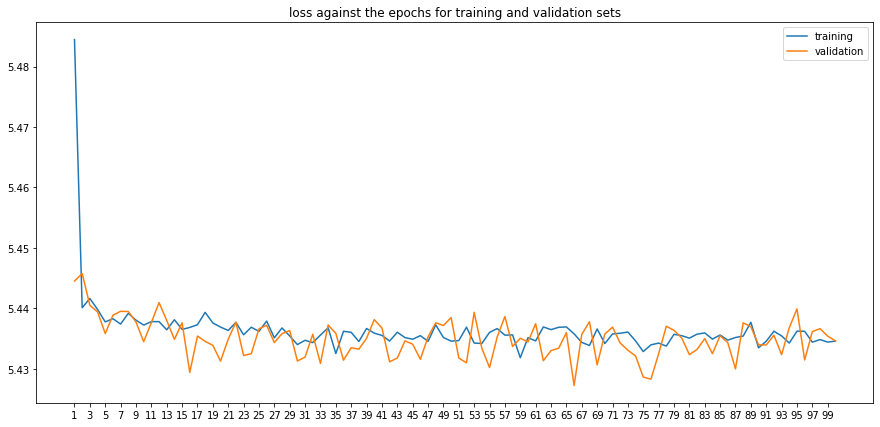

In [9]:
# Plot validation and training losses
epochs = range(1, args_vae.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("loss against the epochs for training and validation sets")
plt.plot(epochs, vae.logs["train loss"], label="training")
plt.plot(epochs, vae.logs["val loss"], label="validation")
plt.xticks(range(1, args_vae.epochs+1, 2))
# plt.ylim(0, 40)
plt.legend(loc=1)
plt.show()

In [10]:
# Generation 
data_vae = generate_vae(vae, test.shape[0], args_vae)
data_vae = pd.DataFrame(
    min_max_scaler.inverse_transform(data_vae),
    columns=columns)
# Rounding
domain = {}
for col in columns:
    domain[col] = np.unique(train[col])
data_vae = project_samples(data_vae, columns, domain)

synthetic_data["VAE"] = data_vae


## GAN

In [11]:
# Params
batch_size = 64

@dataclass
class Arguments_ae:
  # Data
  data_folder: str = ''
  batch_size: int = batch_size
  # Model
  input_dim: int = 9
  latent_dim: int = 64  # Overcomplete AE
  hidden: Tuple[int, ...] = (32,)
  # Optimization
  lr: float = 1e-3
  epochs: int = 50 
  p_zero: float = None  # if not None: Denoising AE 
  # Miscellaneous
  device: str = 'cpu'

@dataclass
class Arguments_gan:
  # Data
  data_folder: str = ''
  batch_size: int = batch_size
  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = True
  hidden_D: Tuple[int, ...] = (32,)
  hidden_G: Tuple[int, ...] = (32,)
  # Optimization (inspired by WGAN paper)
  n_critic: int = 5
  lr: float = 0.00005
  epochs: int = 50
  lambda_gp: int = 10
  # Miscellaneous
  device: str = 'cpu'
  decoder: torch.nn.Module = None
  verbose: bool = False

In [12]:
# Data
train_tensor = torch.tensor(train.values, dtype=torch.float32)
test_tensor = torch.tensor(test.values, dtype=torch.float32)

train_loader = DataLoader(
    train_tensor,
    batch_size=batch_size,
    shuffle=False)
test_loader = DataLoader(
    test_tensor,
    batch_size=batch_size,
    shuffle=False)

In [13]:
# Autoencoder (Embedding)
args_ae = Arguments_ae(epochs=100)
autoencoder = Autoencoder(args_ae)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input_layer): Linear(in_features=9, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=9, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


In [14]:
# AE's training
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args_ae.lr)
train_autoencoder(autoencoder, train_loader, test_loader, optimizer, args_ae)

In [15]:
# Save decoder
torch.save(autoencoder.decoder, "saved_models/decoder.pt")

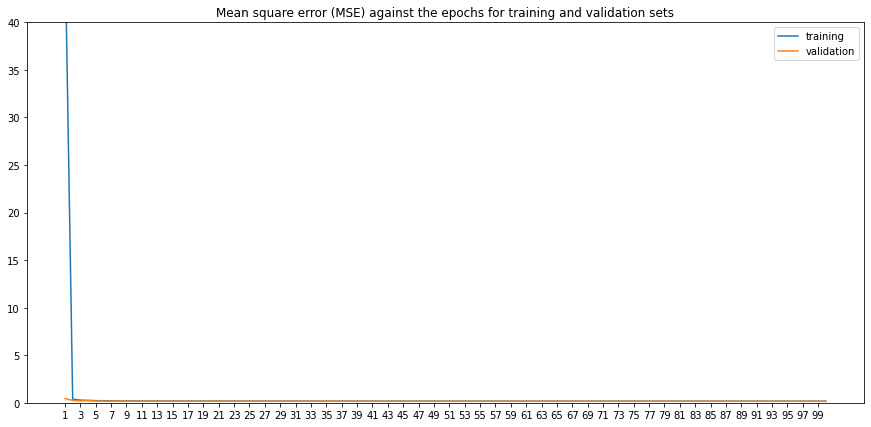

In [16]:
# Plot validation and training losses
epochs = range(1, args_ae.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("Mean square error (MSE) against the epochs for training and validation sets")
plt.plot(epochs, autoencoder.logs["train loss"], label="training")
plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
plt.xticks(range(1, args_ae.epochs+1, 2))
plt.ylim(0, 40)
plt.legend(loc=1)
plt.show()

In [17]:
# GAN
args_gan = Arguments_gan(
    epochs=100,
    decoder=torch.load("saved_models/decoder.pt"))
gan = GAN(args_gan)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList()
      (output_layer): Linear(in_features=32, out_features=9, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=32, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=9, out_features=32, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [18]:
# GAN's training
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args_gan.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args_gan.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args_gan)

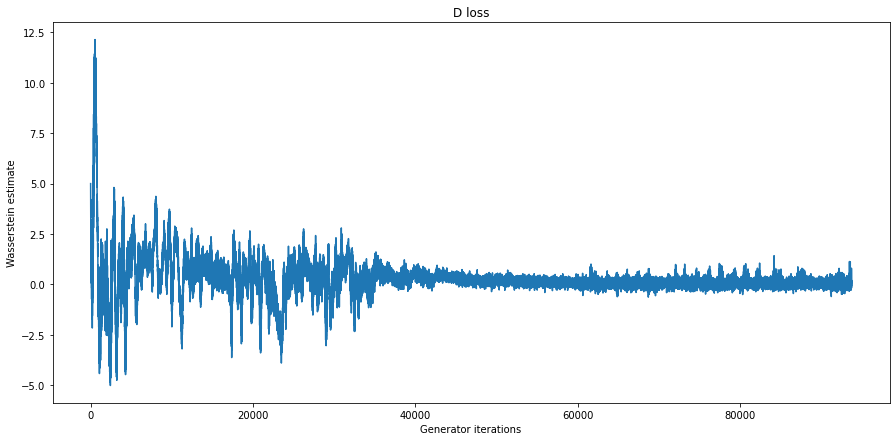

In [19]:
# Wasserstein distance
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

In [20]:
torch.save(gan, "saved_models/gan.pt")
gan = torch.load("saved_models/gan.pt")

In [21]:
# Generation
# TODO: fix round method
gan_data = pd.DataFrame(
    generate_samples(
        gan.G,
        test.shape[0],
        args_gan),
    columns=columns)
# Rounding
gan_data = project_samples(gan_data, columns, domain)

synthetic_data["GAN"] = gan_data

## Bayesian Network

In [22]:
bn = BayesianNetwork.from_samples(train, algorithm="greedy")
bn_data = bn.sample(n=test.shape[0], algorithm="rejection")
bn_data = pd.DataFrame(bn_data ,columns=columns)
synthetic_data["BN"] = bn_data

## Bayesian Network + Copula

In [23]:
scaler = Copula_scaler(train)
train_enc = scaler.encode(train)
bn = BayesianNetwork.from_samples(train_enc, algorithm="greedy")
bn_data = bn.sample(n=test.shape[0], algorithm="rejection")
bn_data = pd.DataFrame(bn_data ,columns=columns)
bn_data = scaler.decode(bn_data)
synthetic_data["BNcopula"] = bn_data

## Evaluation

In [24]:
csTest = CSTest(single_column.statistical.CSTest)
svcDetection = SVCDetection()

In [25]:
# For detection 
n=10000
real_sample = test.sample(n=n)

for model in synthetic_data:
    df = synthetic_data[model]
    # Chi-squared
    cs = csTest.compute(test, df, metadata=metadata)
    results[model]["cs"] = cs
    # Detection (does not scale well wrt rows)
    detection = svcDetection.compute(real_sample, df.sample(n=n), metadata=metadata)
    results[model]["detection"] = detection
    # SRMSE averaged for 2-uples and 3-uples
    for i in range(2,4):
        tuples = list(itertools.combinations(columns, i))  # No repeated elements
        SRMSE = 0 
        for tuple in tuples:
            SRMSE += srmse(
                test.drop(list(columns.difference(tuple)), axis=1),
                df.drop(list(columns.difference(tuple)), axis=1))
        SRMSE /= len(tuples)
        results[model]["SRMSE"+str(i)] = SRMSE
    # SRMSE for all dimensions
    SRMSE = srmse(test, df)
    results[model]["SRMSE"] = SRMSE 

In [26]:
results_df = []

for model in results:
    results_df.append(
        pd.DataFrame({i:results[model][i] for i in results[model]}, index=[model]))

results_df = pd.concat(results_df)
results_df.to_csv("doc/results/marylandMetrics.csv")
results_df

,cs,detection,SRMSE2,SRMSE3,SRMSE
BN,0.999718,0.852751,0.043741,0.064334,0.084825
BNcopula,0.999946,0.839892,0.043979,0.064434,0.084197
GAN,0.739161,0.014992,0.792520,0.742205,0.168963
VAE,0.683296,0.000079,2.050176,2.242270,2.475002


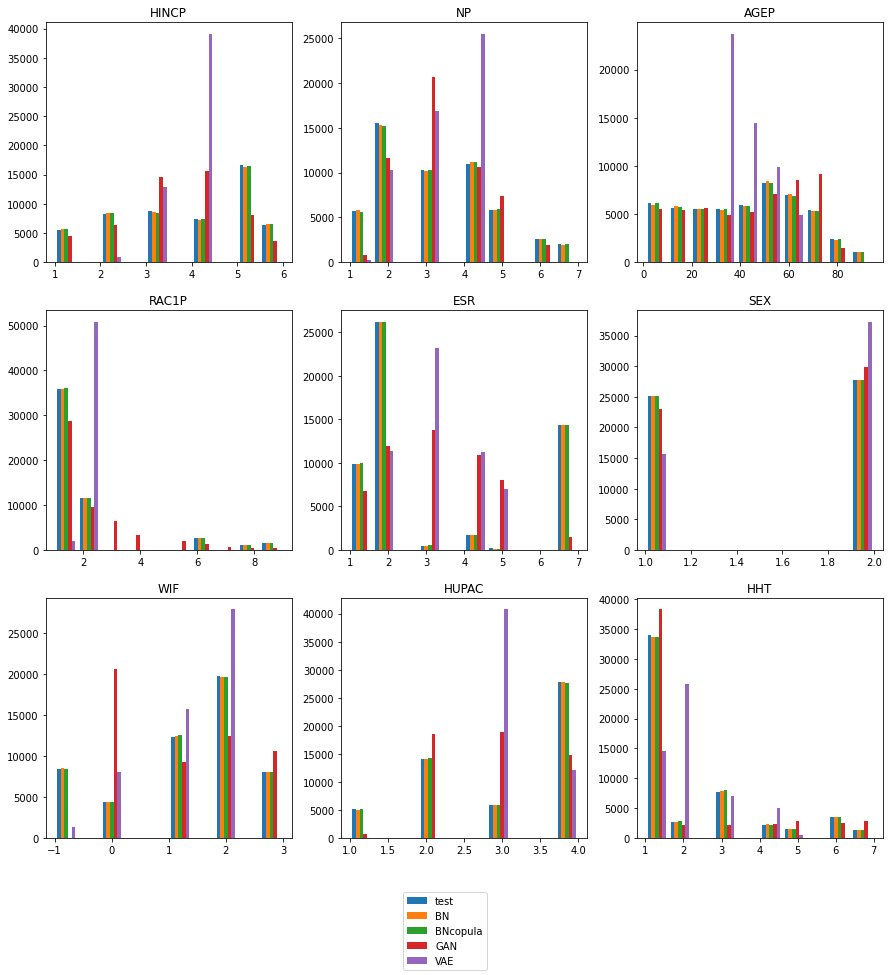

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
k = 0
for i in range(3):
    for j in range(3):
        col = columns[k]
        ax[i, j].hist(
            [test[col]] + [synthetic_data[model][col] for model in models],
            label=["test"] + [model for model in models])
        ax[i, j].set_title(col)
        k += 1
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
plt.show()

# Whole Maryland to pumas

## Data

In [28]:
# data_dir = "data/data"
# dfs = []
# for subdir, dirs, files in os.walk(data_dir):
#     for file in files:
#         path = os.path.join(subdir, file)
#         if path == "data/data/.DS_Store":
#             continue
#         dfs.append(pd.read_csv(os.path.join(subdir, file)))
# df = pd.concat(dfs)
# df.to_csv("data/maryland.csv", index=False)


In [29]:
source = pd.read_csv("data/maryland.csv").sample(frac=1)  # Whole Maryland
target_urban = pd.read_csv("data/data/Anne Arundel/PUMA_1201_Sample_Treated.csv").sample(frac=1)  # PUMA 1201 Anne Arundel
target_rural = pd.read_csv("data/data/Frederick/PUMA_301_Sample_Treated.csv").sample(frac=1)  # PUMA 301 Frederick

columns = source.columns.drop(["PUMA"])

source_independant = source.copy()  # Same but independant marginals
for col in columns:
    new_col = source_independant[col].sample(frac=1)  # Bootstrap
    source_independant.drop([col], axis=1, inplace=True)
    source_independant[col] = new_col.reset_index(drop=True)

for df in [source, source_independant, target_urban, target_rural]:
    df.drop(["PUMA"], axis=1, inplace=True)

## Synthetic population

We generate urban and rural regions from the whole Maryland population.

### Generation

In [30]:
# Tools to apply probability integral transform and pseudo inverse
source_scaler = Copula_scaler(source)
source_independant_scaler = Copula_scaler(source_independant)
target_urban_scaler = Copula_scaler(target_urban)
target_rural_scaler = Copula_scaler(target_rural)

In [31]:
# # Save marginals for IPF 
# dfs_urban = []
# dfs_rural = []
# for col in columns:
#     df_urban = pd.DataFrame(target_urban_scaler.uniques[col], columns=["Class", "CDF"])
#     df_urban["Marginal"] = col
#     dfs_urban.append(df_urban)
#     df_rural = pd.DataFrame(target_rural_scaler.uniques[col], columns=["Class", "CDF"])
#     df_rural["Marginal"] = col
#     dfs_rural.append(df_rural)
# df_urban = pd.concat(dfs_urban)
# df_urban.to_csv("data/pumaMarginals/marginals1201.csv",index=False)
# df_rural = pd.concat(dfs_rural)
# df_rural.to_csv("data/pumaMarginals/marginals301.csv",index=False)

In [32]:
# Data dictionaries. Will hold synthetic data and results
sources = {
    "source": {"df": source, "scaler": source_scaler},
    "source ind": {"df": source_independant, "scaler": source_independant_scaler}
    }

targets = {
    "urban": {"df": target_urban, "scaler": target_urban_scaler, "source":{}, "source ind":{}},
    "rural": {"df": target_rural, "scaler": target_rural_scaler, "source":{}, "source ind":{}}
    }

In [33]:
# Synthetic data generation
for source_key, source_value in sources.items():
    source_scaler = source_value["scaler"]
    source_df = source_value["df"]
    copula_uniform = source_scaler.encode(source_df)  # Apply ECDF
    model = BayesianNetwork.from_samples(copula_uniform, algorithm="greedy")  # Bayesian network
    for target_key, target_value in targets.items():
        target_scaler = target_value["scaler"]
        target_df = target_value["df"]
        synthetic = model.sample(n=target_df.shape[0], algorithm="rejection")  # Sampling
        synthetic = pd.DataFrame(synthetic, columns=columns)
        synthetic = source_scaler.resampling_trick(synthetic)  # Uniform resampling trick
        synthetic = target_scaler.decode(synthetic)  # Apply pseudo inverse
        targets[target_key][source_key]["df"] = synthetic

### Visualization

### Quantitative tests

In [34]:
csTest = CSTest(single_column.statistical.CSTest)
svcDetection = SVCDetection()

for t in targets:
    target = targets[t]["df"]
    for s in sources:
        synthetic = targets[t][s]["df"]
        # Chi-squared
        cs = csTest.compute(target, synthetic, metadata=metadata)
        targets[t][s]["cs"] = cs
        # Detection 
        detection = svcDetection.compute(target, synthetic, metadata=metadata)
        targets[t][s]["detection"] = detection
        # SRMSE averaged for 2-uples, 3-uples and 4-uples
        for i in range(2,5):
            tuples = list(itertools.combinations(columns, i))  # No repeated elements
            SRMSE = 0 
            for tuple in tuples:
                SRMSE += srmse(
                    target.drop(list(columns.difference(tuple)), axis=1),
                    synthetic.drop(list(columns.difference(tuple)), axis=1))
            SRMSE /= len(tuples)
            targets[t][s]["SRMSE"+str(i)] = SRMSE
        # SRMSE for all dimensions
        SRMSE = srmse(target, synthetic)
        targets[t][s]["SRMSE"] = SRMSE 


In [35]:
results = []

for t in targets:
    for s in sources:
        results.append(
            pd.DataFrame({i:targets[t][s][i] for i in targets[t][s] if i!='df'}, index=[t+" "+s]))

results = pd.concat(results)
results.to_csv("doc/results/metrics.csv")
results

,cs,detection,SRMSE2,SRMSE3,SRMSE4,SRMSE
urban source,0.997773,0.687377,0.142313,0.207568,0.232492,0.217548
urban source ind,0.998724,0.238904,0.230379,0.326980,0.342221,0.225532
rural source,0.999453,0.619556,0.125637,0.194148,0.224825,0.202479
rural source ind,1.000000,0.213071,0.212425,0.332310,0.366994,0.223967


In [36]:
df1202 = synthetic_data["BN"].sample(n=targets["urban"]["df"].shape[0])
print("CS",csTest.compute(targets["urban"]["df"], df1202, metadata=metadata))
print("detection", svcDetection.compute(targets["urban"]["df"], df1202, metadata=metadata))
for i in range(2,5):
    tuples = list(itertools.combinations(columns, i))  # No repeated elements
    SRMSE = 0 
    for tuple in tuples:
        SRMSE += srmse(
            targets["urban"]["df"].drop(list(columns.difference(tuple)), axis=1),
            df1202.drop(list(columns.difference(tuple)), axis=1))
    SRMSE /= len(tuples)
    print("SRMSE",i,SRMSE)

CS 0.9993092666145399
detection 0.7086529355228948
SRMSE 2 0.24604688364764804
SRMSE 3 0.23891144696661834
SRMSE 4 0.22314012051253337


# From pumas to census tract

In [37]:
# Tract marginals
marginals = {}
for col in columns:
    if col in ["ESR", "WIF"]: continue
    marginal = pd.read_csv(f"data/marginalsCensLvl/{col}.csv")
    if col in ["SEX", "HHT", "AGEP", "NP", "RAC1P", "HUPAC"]:
        marginal = marginal.loc[(marginal["PUMA"] == 1201) & (marginal["TRACT"] == 702204)]
    else:
        marginal = marginal.loc[(marginal["PUMA"] == 1201) & (marginal["TRACT"] == 24003702204)]
    marginal = marginal[["CLASS","CDF"]]
    marginal = marginal.iloc[1:]
    marginals[col] = marginal

In [38]:
# Generation
copula_uniform_source = targets["rural"]["scaler"].encode(targets["rural"]["df"])  # Apply ECDF
model = BayesianNetwork.from_samples(copula_uniform_source, algorithm="greedy")  # Bayesian network
synthetic = model.sample(n=source.shape[0], algorithm="rejection")  # Sampling
synthetic = pd.DataFrame(synthetic, columns=columns)
synthetic = targets["rural"]["scaler"].resampling_trick(synthetic)  # Uniform resampling trick
# Decoding
for column in columns.difference(["PUMA"]):
    if column in ["ESR", "WIF"]:
        x_u = np.array(source_scaler.uniques[column])
    else:
        x_u = marginals[column].values
    synthetic[column] = synthetic[column].apply(pseudo_inverse, args=(x_u,))

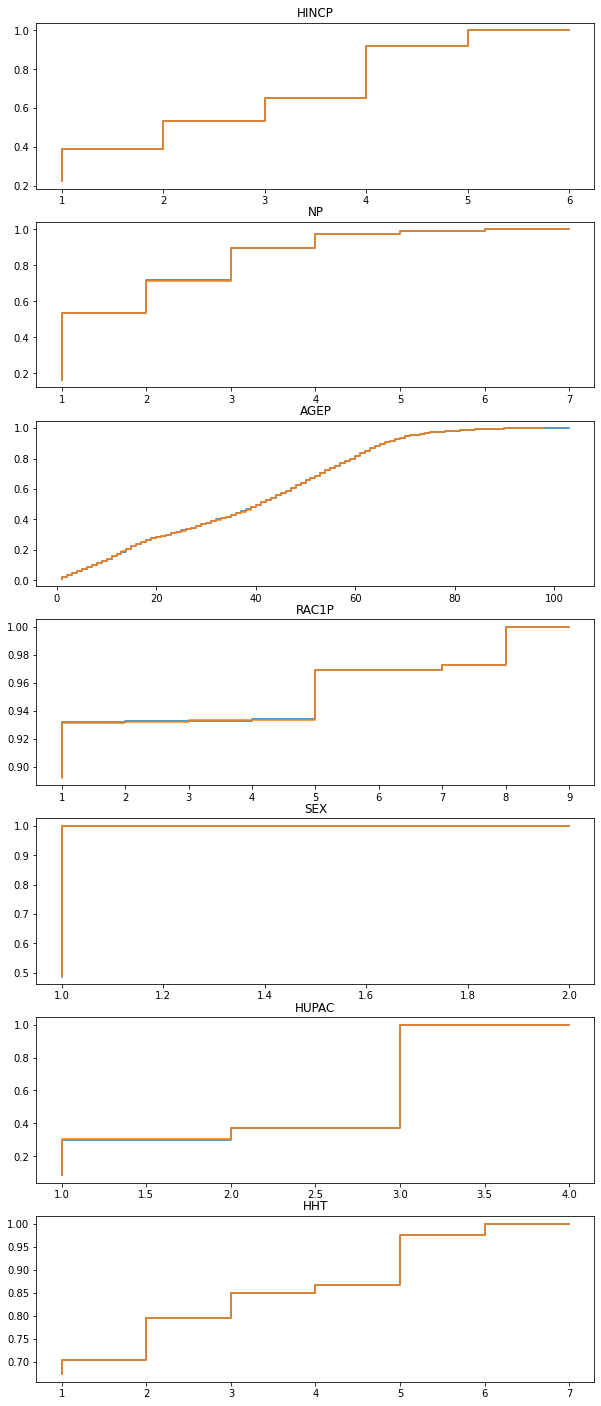

In [39]:
fig, ax = plt.subplots(7,1, figsize=(10,25))
i=0
scaler_synth = Copula_scaler(synthetic)
x_u = scaler_synth.uniques
for col in columns:
    if col in ["ESR", "WIF"]: continue
    ecdf = marginals[col].values
    ecdf_synth = np.array(x_u[col])
    ax[i].step(ecdf[:, 0], ecdf[:, 1])
    ax[i].step(ecdf_synth[:, 0], ecdf_synth[:, 1], label="Synthesis")
    ax[i].set_title(col)
    i+=1